In [1]:
# for dates
import datetime

# data processing
import numpy as np
import pandas
# plotting
import matplotlib.pyplot as plt
# downloading
import requests

# for inline plotting
%matplotlib inline

/Users/baart_f/.virtualenvs/py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# pass menu and collect a cookie
url_menu = 'http://www.marinetraffic.com/en/users/ajax_user_menu/home:1'
# if we have a cookie gather data
url = 'http://www.marinetraffic.com/map/getDataJson/sw_x:-4.0/sw_y:50.0/ne_x:12.0/ne_y:54.0/zoom:7/station:0'

In [3]:
# We are a browser and we came from the home page. 
headers = {
    "Referer": "http://www.marinetraffic.com",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.116 Safari/537.36"
}
# now we go to the menu page
response = requests.get(url_menu, headers=headers)

# and we get the cookie that we need
cookies = response.cookies
dict(cookies)

{'CAKEPHP': 'hq7od1ha3qfa56l5r6kof9bel6', 'SERVERID': 'www7'}

In [4]:
# now we can gather data
response = requests.get(url, headers=headers, cookies=cookies)
# and convert it to json
data = response.json()

In [5]:
# this is the relevant part
rows = data['data']['rows']
# this is the other information, not that relevant
data['type'], data['data']['areaShips'], data['data']['totalShips']

(1, 9851, 81361)

In [6]:
# let's make a table
# we need certain properties as numbers so convert them as everything is returned as strings
ships =  [
    {
        "id": int(row["SHIP_ID"]),
        "lat": float(row['LAT']), 
        "lon": float(row['LON']), 
        "heading": int(row['HEADING']),
        "speed": float(row["SPEED"])/10.0,
        **row
    } for row in rows
]
# read them into a dataframe
df = pandas.DataFrame.from_records(ships)
# and use the ship id as an index
df = df.set_index('id')

# Cleanup

In [7]:
# 511 is missing (still ints, so we can use ==)
df.loc[df['heading'] == 511, 'heading'] = None
# unfortunately 0 is also missing, so we have to drop all 
df.loc[df['heading'] == 0, 'heading'] = None

# compute direction in rad, also from 0 up clockwise to 0 right, counterclockwise)
df['direction'] =  -df['heading'].apply(np.deg2rad)  + 0.5*np.pi

# and split in u,v components, for plotting
df['u'] = np.cos(df['direction']) 
df['v'] = np.sin(df['direction']) 

# suppose we run this every 10 minutes or so, store in a file
now = datetime.datetime.utcnow()

filename = 'marinetraffic-extract-%f.json' % (now.timestamp(), )
df.to_json(filename)
# toss out the missings 
df = df.dropna()


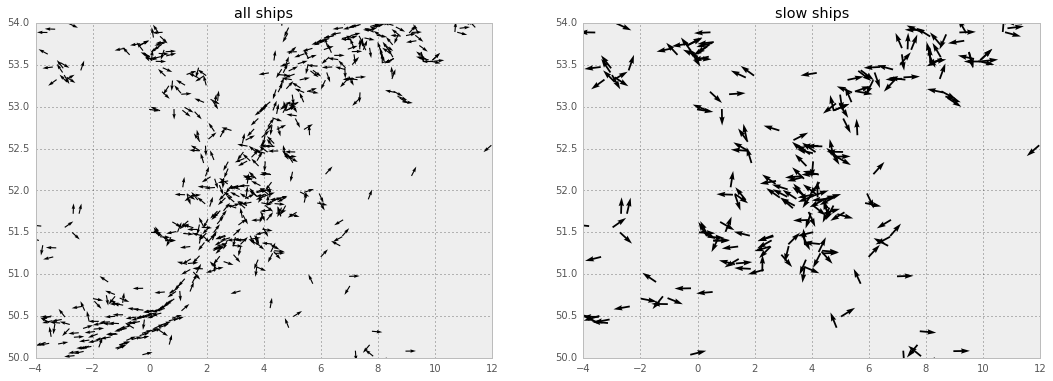

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].set_title('all ships')
axes[0].quiver(df['lon'], df['lat'], df['u'], df['v'])
selection = df.ix[df['speed'] < 1.0]
axes[1].set_title('slow ships')
axes[1].quiver(selection['lon'], selection['lat'], selection['u'], selection['v'])

In [10]:
# information that we collected
df.iloc[0]

COURSE               288
DESTINATION       DUBLIN
ELAPSED                3
FLAG                  BB
HEADING              280
LAT             51.42816
LENGTH                88
LON            -3.996177
ROT                 -720
SHIPNAME           JUMBO
SHIPTYPE               7
SHIP_ID           379285
SPEED                 54
WIDTH                 14
heading              280
lat              51.4282
lon             -3.99618
speed                5.4
direction       -3.31613
u              -0.984808
v               0.173648
Name: 379285, dtype: object

In [11]:
len(df)

591